In [1]:
"""
Premier pas vers l’industrialisation avec les pipelines scikit
"""
!pip install duckdb

     --------------------------------------- 11.0/11.0 MB 13.4 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: C:\Users\dmarin\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
# # Création du pipeline:

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

estimators = [("reduce_dim", PCA()), ("clf", SVC())]
pipe = Pipeline(estimators)

param_grid = {"reduce_dim__n_components": [2, 5, 10], "clf__C": [0.1, 10, 100]}
grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search

GridSearchCV(estimator=Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())]),
             param_grid={'clf__C': [0.1, 10, 100],
                         'reduce_dim__n_components': [2, 5, 10]})

In [6]:
# # Récupération des données:
import requests
import os

url = "https://www.data.gouv.fr/fr/datasets/r/56bde1e9-e214-408b-888d-34c57ff005c4"
file_name = "data/dvf.parquet"

# Check if the file already exists
if not os.path.exists(file_name):
    response = requests.get(url)

    if response.status_code == 200:
        with open(file_name, "wb") as f:
            f.write(response.content)
        print("Téléchargement réussi.")
    else:
        print(f"Échec du téléchargement. Code d'état : {response.status_code}")
else:
    print(f"Le fichier '{file_name}' existe déjà. Aucun téléchargement nécessaire.")

Téléchargement réussi.


In [7]:
# # Chargement du fichier téléchargé avec duckDB ou pandas:

# # Version duckDB:
import duckdb
# 
# duckdb.sql(f'CREATE OR REPLACE VIEW dvf AS SELECT * FROM read_parquet("dvf.parquet")')
# duckdb.sql(f"SELECT * FROM dvf LIMIT 5")

# # Version Pandas:
df = pd.read_parquet(file_name)
df.head(2)

,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
0,None,None,None,None,None,None,None,000001,2022-01-03,Vente,...,None,1,2.0,Appartement,None,24.0,1.0,None,None,NaN
1,None,None,None,None,None,None,None,000001,2022-01-03,Vente,...,None,0,NaN,None,None,NaN,NaN,S,None,84.0


In [30]:
# # Séléction des variables:
xvars = [
    "Date mutation",
    "Valeur fonciere",
    "Nombre de lots",
    "Code type local",
    "Nombre pieces principales",
]

# # Version duckDB:

# xvars = ", ".join([f'"{s}"' for s in xvars])  # pour duckDB
# mutations = duckdb.sql(
#     f"""
#     SELECT
#     date_part('month', "Date mutation") AS month,
#     substring("Code postal", 1, 2) AS dep,
#     {xvars},
#     COLUMNS('Surface Carrez.*')
#     FROM dvf
#     """
# ).to_df()
# 
# colonnes_surface = mutations.columns[mutations.columns.str.startswith("Surface Carrez")]
# mutations.loc[:, colonnes_surface] = (
#     mutations.loc[:, colonnes_surface]
#     .replace({",": "."}, regex=True)
#     .astype(float)
#     .fillna(0)
# )

# # Version Pandas:
df.loc[:, 'month'] = pd.to_datetime(df['Date mutation']).dt.month
df.loc[:, 'dep'] = df['Code postal'].str[0:2]
col_surface = [col for col in df.columns if col.startswith('Surface Carrez')]
columns = ['month', 'dep'] + xvars + col_surface
mutations = df.loc[:, columns]

for col in col_surface:
    mutations[col] = mutations[col].str.replace(',', '.').astype(float)
# print(set(mutations['Date mutation'].tolist()))
mutations.head()

,month,dep,Date mutation,Valeur fonciere,Nombre de lots,Code type local,Nombre pieces principales,Surface Carrez du 1er lot,Surface Carrez du 2eme lot,Surface Carrez du 3eme lot,Surface Carrez du 4eme lot,Surface Carrez du 5eme lot
0,1,01,2022-01-03,55000.0,1,2.0,1.0,24.10,NaN,NaN,NaN,NaN
1,1,01,2022-01-03,143000.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,01,2022-01-03,143000.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,01,2022-01-03,143000.0,1,2.0,3.0,123.23,NaN,NaN,NaN,NaN
4,1,01,2022-01-04,300.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# # Effet confinement:
import datetime as dt

# # Version DuckDB:
# mutations["confinement"] = (
#     mutations["Date mutation"]
#     .between(pd.to_datetime("2020-03-17"), pd.to_datetime("2020-05-03"))
#     .astype(int)
# )

# # Version Pandas:
idx = mutations.loc[(mutations["Date mutation"]>=dt.date(2020, 3, 17)) & (mutations["Date mutation"]<=dt.date(2020, 5, 3))].index
mutations.loc[idx, 'confinement'] = True 
mutations.loc[mutations['confinement']==True].head()  # pas de données pendant le confinement

,month,dep,Date mutation,Valeur fonciere,Nombre de lots,Code type local,Nombre pieces principales,Surface Carrez du 1er lot,Surface Carrez du 2eme lot,Surface Carrez du 3eme lot,Surface Carrez du 4eme lot,Surface Carrez du 5eme lot,confinement


C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,month,dep,Date mutation,Valeur fonciere,Nombre de lots,Code type local,Nombre pieces principales,Surface Carrez du 1er lot,Surface Carrez du 2eme lot,Surface Carrez du 3eme lot,Surface Carrez du 4eme lot,Surface Carrez du 5eme lot,lprix,surface
0,1,01,2022-01-03,55000.0,1,2.0,1.0,24.1,NaN,NaN,NaN,NaN,10.915088,24.1
1,1,01,2022-01-03,143000.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.870600,0.0


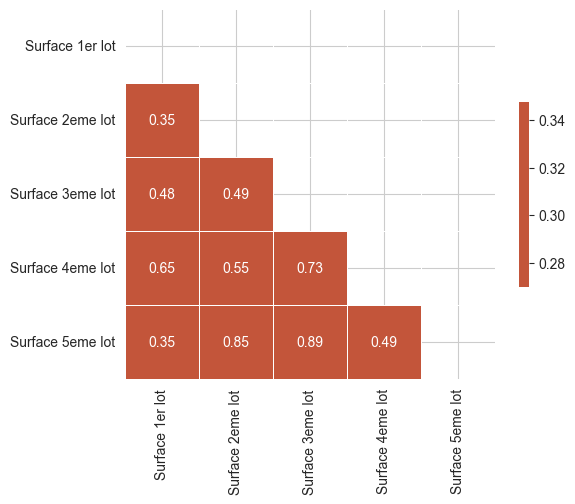

In [33]:
# # Création de variable surface qui agrège les différentes colonnes de surface:
corr = mutations.loc[
    :, mutations.columns[mutations.columns.str.startswith("Surface Carrez")].tolist()
]
corr.columns = corr.columns.str.replace("Carrez du ", "")
corr = corr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(1)
g = sns.heatmap(
    corr,
    ax=ax,
    mask=mask,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    cmap=cmap,
    annot=True,
    fmt=".2f",
)
g  # ==> variables faiblement corrélées mais on les agrège quand même pour la simplicité de l'exercice

mutations["lprix"] = np.log(mutations["Valeur fonciere"])
mutations["surface"] = mutations.loc[:, col_surface].sum(axis=1).astype(int)
mutations["surface"] = mutations.loc[
    :, mutations.columns[mutations.columns.str.startswith("Surface Carrez")].tolist()
].sum(axis=1)
mutations.head(2)

In [37]:
# # 3. Pipeline random forest sur variables standardisées:

from sklearn.model_selection import train_test_split

# # 3.1 Training et testing datasets:

mutations2 = mutations.drop(
    col_surface
    + ["Date mutation", "lprix"],  # ajouter "confinement" si données 2020
    axis="columns",
).copy()

mutations2 = mutations2.loc[
    mutations2["Valeur fonciere"] < 5e6
]  # keep only values below 5 millions

mutations2.columns = mutations2.columns.str.replace(" ", "_")
mutations2 = mutations2.dropna(subset=["dep", "Code_type_local", "month"])

# # Variables numériques et catégorielles:
numeric_features = list(mutations2.columns[
    ~mutations2.columns.isin(["dep", "Code_type_local", "month", "Valeur_fonciere"])
])
categorical_features = ["dep", "Code_type_local", "month"]

# # conservation d'un sous-ensemble distribué sur les départements pour accélérer les calculs
mutations2 = mutations2.groupby("dep").sample(frac=0.1, random_state=123)

# # 80% entrainement, 20% test:
X_train, X_test, y_train, y_test = train_test_split(
    mutations2.drop("Valeur_fonciere", axis=1),
    mutations2[["Valeur_fonciere"]].values.ravel(),
    test_size=0.2,
    random_state=123,
    stratify=mutations2[["dep"]],
)


In [39]:
# # 3.2 Définition du permier pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

regr = RandomForestRegressor(max_depth=2, random_state=123)

numeric_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
transformer = make_column_transformer(
    (numeric_pipeline, numeric_features),
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features),
)
pipe = Pipeline(steps=[("preprocessor", transformer), ("randomforest", regr)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Nombre_de_lots',
                                                   'Nombre_pieces_principales',
                                                   'surface']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['dep', 'Code_type_local',
                                                   'month'])])),
                ('randomforest',
                 RandomForestRegressor(max_depth=2, random_state=123))])

In [40]:
# # 3.3 Mise en oeuvre du pipeline:

# # Paramètres du modèle sur le jeu d'entrainement:
pipe.fit(X_train, y_train)

# # Observation de la transformation des données d'entrainement par l'étape de pré-processing:
pipe[:-1].transform(X_train.sample(4))

array([[-0.71528031,  0.59163683, -0.27662483,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [41]:
pipe.predict(X_test)

array([282871.63598981, 301165.65351098, 301165.65351098, ...,
       282871.63598981, 471048.40037679, 282871.63598981])

In [43]:
# # 3.4
from sklearn.metrics import mean_squared_error

X_fictif = pd.DataFrame(
    {
        "month": [3, 12],
        "dep": ["75", "06"],
        "Nombre_de_lots": [1, 2],
        "Code_type_local": [2, 1],
        "Nombre_pieces_principales": [3.0, 6.0],
        "surface": [75.0, 180.0],
    }
)
pipe[:-1].transform(X_fictif)
pipe.predict(X_fictif)
np.sqrt(mean_squared_error(pipe.predict(X_test), y_test))

np.float64(433497.6437239088)

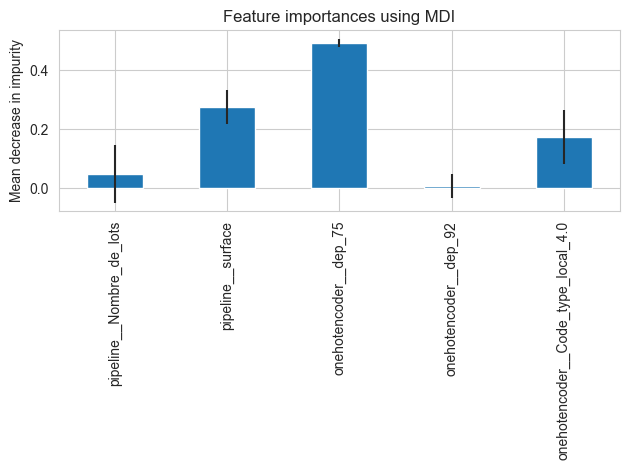

In [44]:
# # Exercice 4: compréhension du modèle
features_names = pipe[:-1].get_feature_names_out()
importances = pipe["randomforest"].feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in pipe["randomforest"].estimators_], axis=0
)

forest_importances = pd.DataFrame(importances, index=features_names, columns=["mdi"])
forest_importances["std"] = std

fig, ax = plt.subplots()
forest_importances.loc[forest_importances["mdi"] > 0, "mdi"].plot.bar(
    yerr=forest_importances.loc[forest_importances["mdi"] > 0, "std"], ax=ax
)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

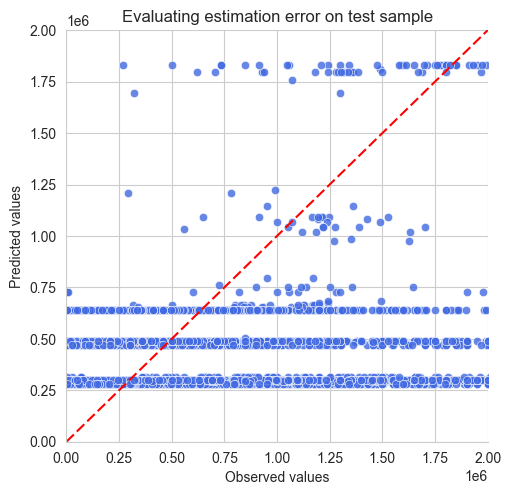

In [45]:
# # comparaison prédictions vs observations:
compar = pd.DataFrame([y_test, pipe.predict(X_test)]).T
compar.columns = ["obs", "pred"]
compar["diff"] = compar.obs - compar.pred
g = sns.relplot(data=compar, x="obs", y="pred", color="royalblue", alpha=0.8)
g.set(
    ylim=(0, 2e6),
    xlim=(0, 2e6),
    title="Evaluating estimation error on test sample",
    xlabel="Observed values",
    ylabel="Predicted values",
)
g.ax.axline(xy1=(0, 0), slope=1, color="red", dashes=(5, 2))

In [47]:
# # Restriction du champ du modèle:
mutations_paris = mutations.drop(
    col_surface
    + ["Date mutation", "lprix"],  # ajouter "confinement" si données 2020
    axis="columns",
).copy()

mutations_paris = mutations_paris.loc[
    mutations_paris["Valeur fonciere"] < 5e6
]  # keep only values below 5 millions

mutations_paris.columns = mutations_paris.columns.str.replace(" ", "_")
mutations_paris = mutations_paris.dropna(subset=["dep", "Code_type_local", "month"])
mutations_paris = mutations_paris.loc[mutations_paris["dep"] == "75"]
mutations_paris = mutations_paris.loc[mutations_paris["Code_type_local"] == 2].drop(
    ["dep", "Code_type_local"], axis="columns"
)
mutations_paris.loc[mutations_paris["surface"] > 0]

,month,Valeur_fonciere,Nombre_de_lots,Nombre_pieces_principales,surface
4272176,1,686000.0,1,4.0,73.45
4273807,2,400000.0,1,2.0,41.16
4275450,3,475000.0,3,2.0,47.70
4275883,2,396200.0,2,2.0,47.14
4275884,2,299500.0,1,1.0,34.02
...,...,...,...,...,...
4617521,12,1650000.0,3,6.0,154.75
4617532,12,525000.0,2,3.0,46.65
4617540,12,425000.0,2,1.0,27.85
4617549,12,330000.0,2,2.0,34.32


In [48]:
# # Exercice 4: pipeline plus simple:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split


mutations_paris = mutations.drop(
    col_surface
    + ["Date mutation", "lprix"],  # ajouter "confinement" si données 2020
    axis="columns",
).copy()

mutations_paris = mutations_paris.loc[
    mutations_paris["Valeur fonciere"] < 5e6
]  # keep only values below 5 millions

mutations_paris.columns = mutations_paris.columns.str.replace(" ", "_")
mutations_paris = mutations_paris.dropna(subset=["dep", "Code_type_local", "month"])
mutations_paris = mutations_paris.loc[mutations_paris["dep"] == "75"]
mutations_paris = mutations_paris.loc[mutations_paris["Code_type_local"] == 2].drop(
    ["dep", "Code_type_local", "Nombre_de_lots"], axis="columns"
)
mutations_paris.loc[mutations_paris["surface"] > 0]


numeric_features = mutations_paris.columns[
    ~mutations_paris.columns.isin(["month", "Valeur_fonciere"])
].tolist()
categorical_features = ["month"]

reg = GradientBoostingRegressor(random_state=0)

numeric_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
transformer = make_column_transformer(
    (numeric_pipeline, numeric_features),
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features),
)
pipe = Pipeline(steps=[("preprocessor", transformer), ("boosting", reg)])

X_train, X_test, y_train, y_test = train_test_split(
    mutations_paris.drop("Valeur_fonciere", axis=1),
    mutations_paris[["Valeur_fonciere"]].values.ravel(),
    test_size=0.2,
    random_state=123,
)

pipe.fit(X_train, y_train)

pd.DataFrame(
    pipe["boosting"].feature_importances_, index=pipe[:-1].get_feature_names_out()
)

,0
pipeline__Nombre_pieces_principales,0.268176
pipeline__surface,0.716371
onehotencoder__month_1,0.000309
onehotencoder__month_2,0.001060
onehotencoder__month_3,0.000967
onehotencoder__month_4,0.007498
onehotencoder__month_5,0.000000
onehotencoder__month_6,0.000153
onehotencoder__month_7,0.000156
onehotencoder__month_8,0.000819


In [49]:
# # Recherche des hyperparamètres optimaux avec une validation croisée
pipe["boosting"].get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Elapsed time : 11 seconds


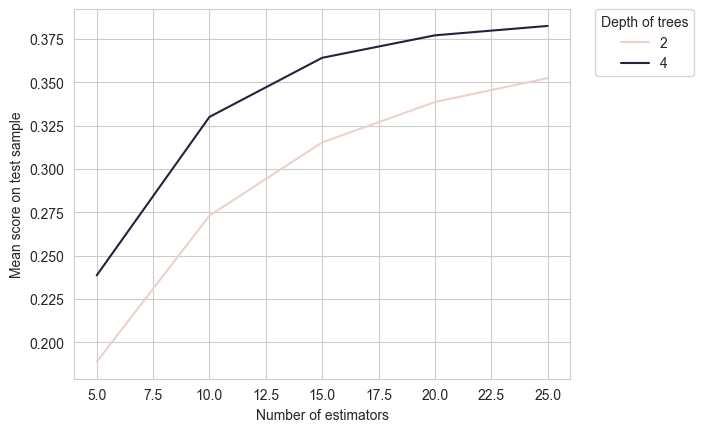

In [52]:
# # Hyperparamètres optimaux et validation croisée:
import numpy as np
from sklearn.model_selection import GridSearchCV

import time

X = pd.concat((X_train, X_test), axis=0)
Y = np.concatenate([y_train, y_test])

start_time = time.time()
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    "boosting__n_estimators": np.linspace(5, 25, 5).astype(int),
    "boosting__max_depth": [2, 4],
}
grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train, y_train)

end_time = time.time()

print(f"Elapsed time : {int(end_time - start_time)} seconds")

perf_random_forest = pd.DataFrame(grid_search.cv_results_)
fig, ax = plt.subplots(1)
g = sns.lineplot(
    data=perf_random_forest,
    ax=ax,
    x="param_boosting__n_estimators",
    y="mean_test_score",
    hue="param_boosting__max_depth",
)
g.set(xlabel="Number of estimators", ylabel="Mean score on test sample")
g
plt.legend(
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Depth of trees"
)

# # Entrainement du modèle avec les paramètres optimaux:
pipe_optimal = grid_search.best_estimator_
pipe_optimal.fit(X_train, y_train)

compar = pd.DataFrame([y_test, pipe_optimal.predict(X_test)]).T
compar.columns = ["obs", "pred"]
compar["diff"] = compar.obs - compar.pred

In [54]:
# # RMSE:
print(
    "Le RMSE sur le jeu de test est {:,}".format(
        int(np.sqrt(mean_squared_error(y_test, pipe_optimal.predict(X_test))))
    )
)

Le RMSE sur le jeu de test est 562,317
